# HW02: Работа с табличными данными в Pandas
**Студент:** Чайка Никита Валентинович  
**Группа:** ИНБО-10-22

## 1. Загрузка данных и первичный осмотр

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

plt.rcParams['font.family'] = 'DejaVu Sans'

In [41]:
file_path = r'C:\Users\nikita\Downloads\S02-hw-dataset.csv'
df = pd.read_csv(file_path)

print(f"Данные успешно загружены. Количество строк: {df.shape[0]}, столбцов: {df.shape[1]}")

Данные успешно загружены. Количество строк: 41, столбцов: 5


In [42]:
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [44]:
# Базовые описательные статистики
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


## 2. Пропуски, дубликаты и контроль качества

In [52]:
missing_ratio = df.isna().mean()
print("Доля пропусков в каждом столбце:")
print(missing_ratio)

duplicate_rows = df.duplicated().sum()
print(f"\nКоличество дублирующих строк: {duplicate_rows}")

Доля пропусков в каждом столбце:
user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

Количество дублирующих строк: 1


In [53]:
suspicious_cases = []

# Проверка возраста
invalid_age = df[(df['age'] <= 0) | (df['age'] > 100)]['age'].dropna().values
if len(invalid_age) > 0:
    suspicious_cases.append(f"{len(invalid_age)} записей с age <= 0 или age > 100: {invalid_age}")

# Проверка отрицательных значений в purchases
negative_purchases = df[df['purchases'] < 0]['purchases'].values
if len(negative_purchases) > 0:
    suspicious_cases.append(f"{len(negative_purchases)} записей с purchases < 0: {negative_purchases}")

# Проверка нулевого или отрицательного revenue
non_positive_revenue = df[df['revenue'] <= 0]['revenue'].values
if len(non_positive_revenue) > 0:
    suspicious_cases.append(f"{len(non_positive_revenue)} записей с revenue <= 0: {non_positive_revenue}")

# Проверка очень высокого revenue (более 2000)
high_revenue = df[df['revenue'] > 2000]['revenue'].values
if len(high_revenue) > 0:
    suspicious_cases.append(f"{len(high_revenue)} записей с revenue > 2000: {high_revenue}")

# Поиск дублирующих строк
duplicates = df[df.duplicated(keep=False)]

print("Подозрительные значения:")
for case in suspicious_cases:
    print(case)
    
if not duplicates.empty:
    print("\nДублирующие строки:")
    print(duplicates)

Подозрительные значения:
1 записей с age <= 0 или age > 100: [120.]
1 записей с purchases < 0: [-1]
4 записей с revenue <= 0: [0 0 0 0]
3 записей с revenue > 2000: [2358 2475 2086]

Дублирующие строки:
    user_id   age country  purchases  revenue
9        10  24.0      RU          7      511
40       10  24.0      RU          7      511


### Анализ качества данных

В ходе анализа были обнаружены следующие проблемы качества данных:

1. **Пропуски**: В столбце age отсутствуют данные для 2 записей, что может повлиять на анализ, связанный с возрастом пользователей.

2. **Дубликаты**: Обнаружена 2 полностью одинаковые строки - 1 дубликат. (user_id=10), что указывает на возможную ошибку при сборе данных.

3. **Подозрительные значения**:
   - Найден пользователь с возрастом 120 лет - это маловероятно для реальных данных, вероятно, ошибка ввода
   - Обнаружена отрицательная покупка (-1) - это невозможно в реальности, вероятно, ошибка при обработке данных о возврате
   - Четыре записи с нулевым доходом (revenue=0) при наличии покупок э то невозможно в реальности
   - Три пользователя с очень высоким доходом (>2000)

4. **Логические противоречия**:
   - Отрицательное количество покупок при положительном доходе
   - Очень высокий доход (2475) при относительно небольшом количестве покупок (11)
   - Нулевой доход при наличии покупок

Рекомендации по очистке данных:
- Удалить дублирующие строки
- Заполнить пропуски в возрасте медианным значением для соответствующей страны
- Проверить и исправить записи с подозрительными значениями
- Исключить записи с отрицательными покупками или классифицировать их как возвраты

## 3. Базовый EDA: группировки и агрегаты

In [46]:
print("Частоты категорий по странам:")
print(df['country'].value_counts())

Частоты категорий по странам:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64


In [47]:
grouped_country = df.groupby('country').agg(
    user_count=('user_id', 'count'),
    avg_age=('age', 'mean'),
    avg_purchases=('purchases', 'mean'),
    avg_revenue=('revenue', 'mean'),
    total_revenue=('revenue', 'sum')
).round(1)

grouped_country

,user_count,avg_age,avg_purchases,avg_revenue,total_revenue
country,,,,,
CN,2,24.0,4.5,1054.0,2108
DE,6,34.6,6.5,1445.5,8673
FR,12,46.2,4.2,675.9,8111
RU,13,30.1,4.8,790.1,10271
US,8,36.7,4.6,557.4,4459


In [48]:
# Создание возрастных групп
df_clean = df.dropna(subset=['age'])
df_clean['age_group'] = pd.cut(df_clean['age'], 
                              bins=[0, 30, 50, 150], 
                              labels=['молодые (18-30)', 'средний (31-50)', 'старшие (51+)'])

grouped_age = df_clean.groupby('age_group').agg(
    avg_purchases=('purchases', 'mean'),
    avg_revenue=('revenue', 'mean'),
    user_count=('user_id', 'count')
)

grouped_age

,avg_purchases,avg_revenue,user_count
age_group,,,
молодые (18-30),4.666667,662.933333,15
средний (31-50),4.941176,1022.764706,17
старшие (51+),4.142857,623.571429,7


### Основные наблюдения по EDA

1. **Распределение по странам**:
   - Больше всего пользователей из России (13 человек) и Франции (12 человек)
   - Минимальное - Китай (2 человека)
   - Германия и Россия имеют наибольшее влияние на общий доход

2. **Поведение по странам**:
   - **Германия**  имеет самый высокий средний доход на пользователя (1445.5), несмотря на небольшое количество пользователей
   - **Германия** также показывает самые высокие показатели по количеству покупок (6.5 в среднем)
   - **Франция** имеет самый низкий средний доход (675.9), несмотря на большое количество пользователей
   - **Россия** генерирует наибольший общий доход (10271) благодаря большому количеству пользователей
   - Данные по **США** показывают наиболее стабильные (наименее разбросанные) значения дохода

3. **Анализ по возрастным группам**:
   - Средняя возрастная группа (31-50 лет) составляет 17 пользователей
   - Старшие пользователи (51+ лет) составляют 7 пользователей
   - Молодые пользователи (18-30 лет) составляют 15 пользователей
   - Средний возраст пользователей - 36.5 лет
   - Средняя возрастная группа имеет самый высокий средний доход (1022.8)
   - Старшие пользователи совершают меньше покупок в среднем (4.14 против 4.94 у средней группы)

4. **Ключевые закономерности**:
   - Германия имеет наивысшую конверсию и средний чек, что делает эту страну наиболее ценной
   - Средняя возрастная группа (31-50 лет) демонстрирует самый высокий доход

Эти наблюдения указывают на то, что нужно использовать разные маркетинговые стратегии для разных стран и возрастных групп пользователей.

## 4. Визуализация данных

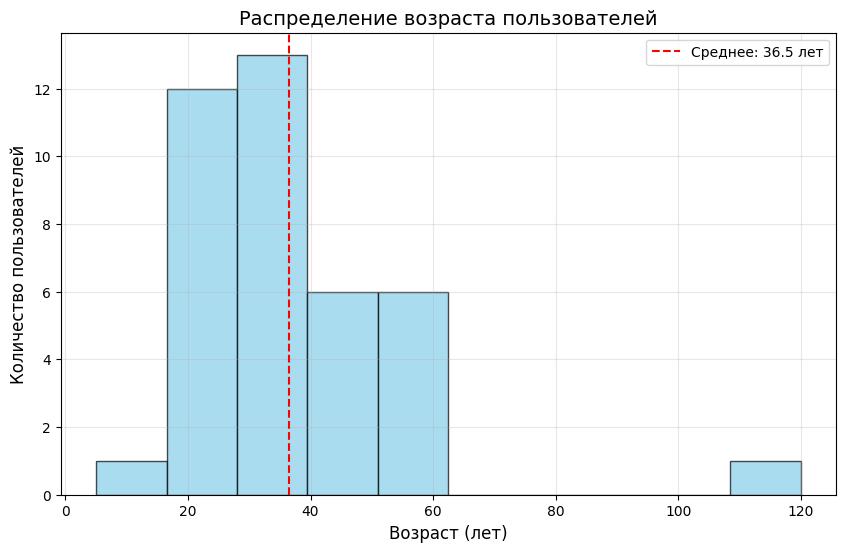

In [49]:
# Гистограмма распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(df['age'].dropna(), bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение возраста пользователей', fontsize=14)
plt.xlabel('Возраст (лет)', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(alpha=0.3)
plt.axvline(x=df['age'].mean(), color='red', linestyle='--', label=f'Среднее: {df["age"].mean():.1f} лет')
plt.legend()
plt.savefig('figures/age_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

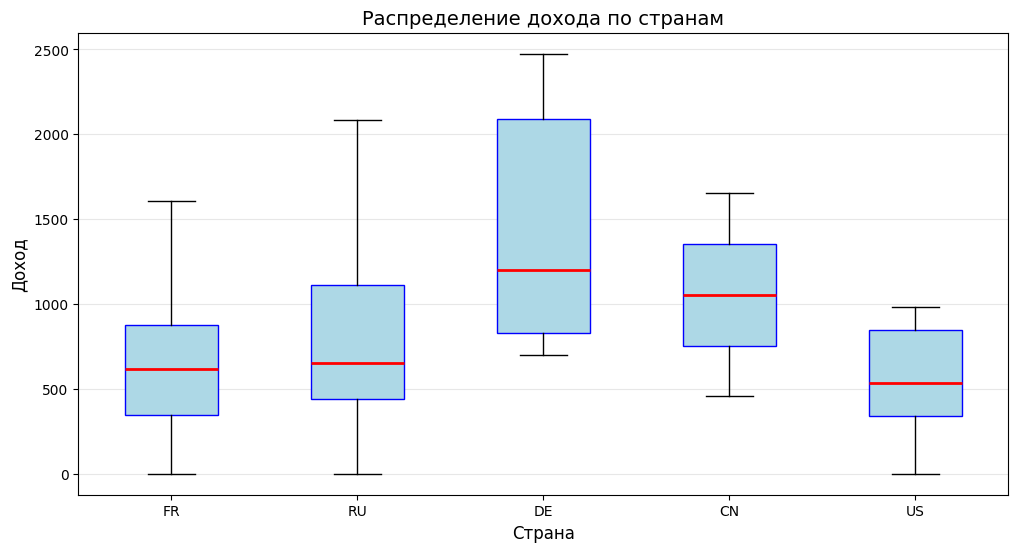

In [54]:
# Boxplot распределения дохода по странам
plt.figure(figsize=(12, 6))

countries = df['country'].unique()
revenue_by_country = [df[df['country'] == country]['revenue'] for country in countries]

boxplot = plt.boxplot(revenue_by_country,
                     labels=countries,
                     patch_artist=True,
                     boxprops=dict(facecolor='lightblue', color='blue'),
                     medianprops=dict(color='red', linewidth=2))

plt.title('Распределение дохода по странам', fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Доход', fontsize=12)
plt.grid(alpha=0.3, axis='y')
plt.savefig('figures/revenue_by_country.png', bbox_inches='tight', dpi=300)
plt.show()

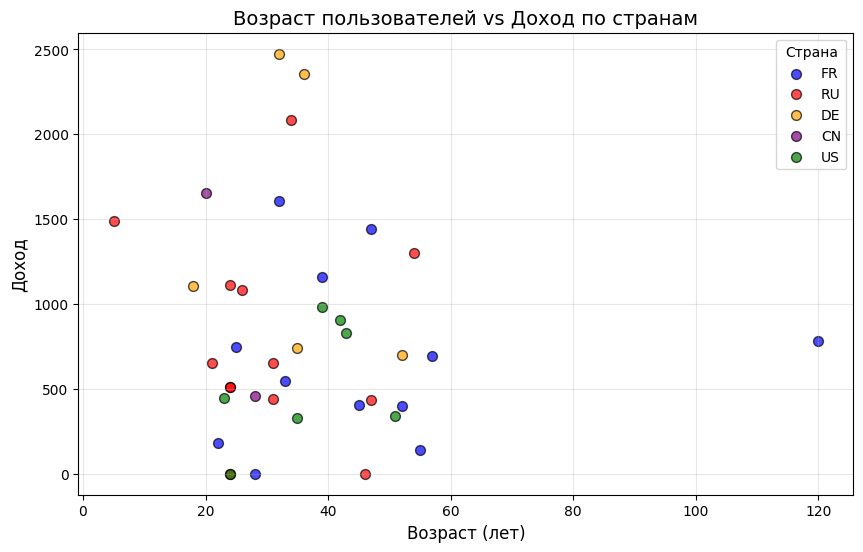

In [55]:
# Scatter plot: возраст vs доход
plt.figure(figsize=(10, 6))

colors = {'RU': 'red', 'FR': 'blue', 'US': 'green', 'DE': 'orange', 'CN': 'purple'}

for country in df['country'].unique():
    subset = df[df['country'] == country]
    plt.scatter(subset['age'], subset['revenue'],
               alpha=0.7, c=colors[country],
               s=50, label=country, edgecolors='black')

plt.title('Возраст пользователей vs Доход по странам', fontsize=14)
plt.xlabel('Возраст (лет)', fontsize=12)
plt.ylabel('Доход', fontsize=12)
plt.legend(title='Страна')
plt.grid(alpha=0.3)
plt.savefig('figures/age_vs_revenue.png', bbox_inches='tight', dpi=300)
plt.show()

### Анализ визуализаций

1. **Гистограмма распределения возраста**:
   - Средний возраст составляет 36.5 лет, что выше медианного значения
   - Присутствуют выбросы как в младшем возрасте (пользователь 5 лет), так и в старшем (пользователь 120 лет), что требует проверки данных

2. **Boxplot дохода по странам**:
   - **Германия** демонстрирует самые высокие доходы на пользователя (наиболее высокая медиана) и самый широкий разброс значений
   - **Россия** имеет широкий диапазон доходов от 0 до 2475, но у Германии разброс еще шире
   - **Франция** показывает относительно стабильные, но невысокие доходы
   - **США** показывают наиболее стабильные (наименее разбросанные) данные при относительно низком медианном доходе
   - **Китай** и **Германия** имеют самые высокие максимальные значения дохода

3. **Scatter plot: возраст vs доход**:
   - Нет четкой линейной зависимости между возрастом и доходом
   - Самые высокие доходы (около 2500) наблюдаются у пользователей из **Германии** (DE, желтые точки) в возрасте 30-35 лет
   - Пользователи в возрасте 25-45 лет демонстрируют наибольший разброс доходов и включают основной кластер пользователей с доходом около 1000-1200
   - Присутствуют выбросы с нулевым доходом при разном возрасте (особенно заметны в России)
   - Средняя возрастная группа (25-45 лет) содержит наибольшее количество пользователей с высоким доходом (1500+)
   - Молодые пользователи (до 25 лет) в основном имеют доход ниже 1000

4. **Практические выводы**:
   - **Целевая аудитория**: Для маркетинга следует делать акцент на возрастной группе 25-45 лет как самой многочисленной и с высоким доходом. Особенно перспективна группа 30-35 лет в Германии.
   - **Географическая стратегия**: Страны с высоким средним чеком (Германия, Китай) требуют особого внимания и персонализированного подхода. В Германии самый высокий уровень конверсии и средний чек, поэтому этот рынок для нас самый важный
   - **Очистка данных**: Необходимо расследовать аномалии в данных (возраст 5 лет и 120 лет, нулевые/отрицательные доходы) для принятия решений. Особенно важно проверить записи с отрицательными покупками
   - **Продуктовые рекомендации**: Для Германии рекомендуется предлагать премиальные продукты с высокой стоимостью, в то время как для Франции - более доступные варианты с акцентом на объем продаж
   - **Технические улучшения**: Учитывая дубликаты и пропуски в данных, рекомендуется провести дополнительную очистку данных перед использованием в моделях и автоматизации процессов
   - **Мониторинг качества**: Необходимо внедрить постоянный мониторинг качества данных для предотвращения появления аналогичных аномалий в будущем
   
   Эти выводы позволяют создать более эффективную маркетинговую стратегию и улучшить качество данных для дальнейшего анализа и принятия решений